# Imports

In [50]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score

In [2]:
def load_tfds_data(dataset):
    ds = tfds.load(dataset, split='train', as_supervised=True)
    images, labels = [], []

    for img, label in tfds.as_numpy(ds):
        images.append(img)
        labels.append(label)
    
    X = np.array(images, dtype=object)
    y = np.array(labels)
    return X, y

2025-06-02 15:38:42.204905: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


(23262,)
(23262,)


2025-06-02 15:38:49.932992: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Dataset

In [ ]:
# Dataset
X, y = load_tfds_data("cats_vs_dogs")

print(X.shape)
print(y.shape)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, stratify=y, random_state=42)

# Pipeline Test

In [5]:
class ImageFlattener(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.reshape(X.shape[0], -1)
    

class ResizeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, size=(64, 64)):
        self.size = size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        resized = np.array([
            tf.image.resize(img, self.size).numpy()
            for img in X
        ])
        return resized

In [ ]:
pipeline = Pipeline([('resize', ResizeTransformer(size=(64, 64))),
                     ('flatten', ImageFlattener()),
                     ('scaler', StandardScaler()),
                     ('clf', LogisticRegression(max_iter=1000))])

In [10]:
pipeline.fit(X_train, y_train)

/Users/zenna/miniconda3/envs/sedct/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('resize', ResizeTransformer()), ('flatten', ImageFlattener()),
                ('scaler', StandardScaler()),
                ('clf', LogisticRegression(max_iter=1000))])

In [ ]:
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Cat", "Dog"]))

Accuracy: 0.5587792821835375

Classification Report:
              precision    recall  f1-score   support

         Cat       0.56      0.59      0.57      2332
         Dog       0.56      0.52      0.54      2321

    accuracy                           0.56      4653
   macro avg       0.56      0.56      0.56      4653
weighted avg       0.56      0.56      0.56      4653



In [13]:
# Save pipeline to a file
joblib.dump(pipeline, "pipeline_model.joblib")

['pipeline_model.joblib']

In [6]:
pipeline = joblib.load("pipeline_model.joblib")
pipeline

Pipeline(steps=[('resize', ResizeTransformer()), ('flatten', ImageFlattener()),
                ('scaler', StandardScaler()),
                ('clf', LogisticRegression(max_iter=1000))])

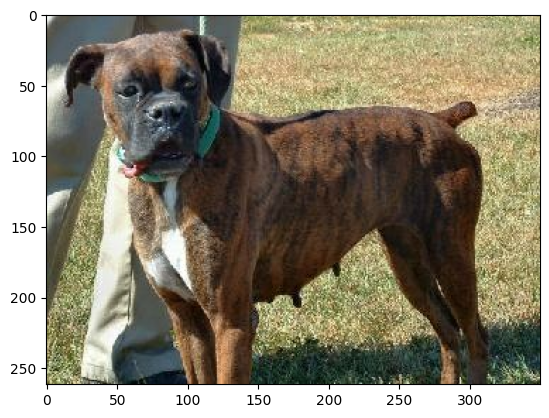

In [7]:
img1 = X[0]
plt.imshow(img1)

In [8]:
img1.shape

(262, 350, 3)

In [11]:
img1= np.expand_dims(img1, axis=0)

In [14]:
y_img1 = [y[0]]

In [17]:
pred = pipeline.predict(img1)
score = pipeline.score(img1, y_img1)
pred_prob = pipeline.predict_proba(img1)

print('Img1 label: ', [str(x) for x in y_img1])
print(pred, score, pred_prob)

Img1 label:  ['1']
[1] 1.0 [[4.87967588e-04 9.99512032e-01]]


# Single Model

## Random Forest classifier

In [4]:
IMG_SIZE = (64, 64)

def resize_batch(X, size):
    return np.array([tf.image.resize(img, size).numpy() for img in X])

# Resize
X_train_resized = resize_batch(X_train, IMG_SIZE)
X_test_resized = resize_batch(X_test, IMG_SIZE)

# Flatten 
X_train_flat = X_train_resized.reshape(len(X_train_resized), -1)
X_test_flat = X_test_resized.reshape(len(X_test_resized), -1)

In [5]:
# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_flat, y_train)

RandomForestClassifier(random_state=42)

In [8]:
# Evaluate
y_pred = clf.predict(X_test_flat)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Cat", "Dog"]))

Accuracy: 0.660649043627767

Classification Report:
              precision    recall  f1-score   support

         Cat       0.65      0.71      0.68      2332
         Dog       0.68      0.61      0.64      2321

    accuracy                           0.66      4653
   macro avg       0.66      0.66      0.66      4653
weighted avg       0.66      0.66      0.66      4653



In [9]:
joblib.dump(clf, "randomforest_model.joblib")

['randomforest_model.joblib']

## RandomSearchCV

In [23]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X, y, train_size=4000, test_size=400, stratify=y, random_state=42)


IMG_SIZE = (64, 64)

def preprocess_images(X, size=(64, 64)):
    X_resized = np.array([tf.image.resize(img, size).numpy() for img in X])
    return X_resized.reshape(len(X_resized), -1)

X_train_proc = preprocess_images(X_train_small, IMG_SIZE)
X_test_proc = preprocess_images(X_test_small, IMG_SIZE)

In [26]:
param_dist = {
    "n_estimators": [50, 100],
    "max_depth": [10, 20, 30],
    "min_samples_split": [2, 5, 7],
    "min_samples_leaf": [1, 2, 3],
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=8,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_proc, y_train_small)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=8, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 5, 7],
                                        'n_estimators': [50, 100]},
                   random_state=42, verbose=1)

In [27]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test_proc)
print("Accuracy:", accuracy_score(y_test_small, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_small, y_pred, target_names=["Cat", "Dog"]))

Accuracy: 0.6425

Classification Report:
              precision    recall  f1-score   support

         Cat       0.62      0.73      0.67       200
         Dog       0.67      0.55      0.61       200

    accuracy                           0.64       400
   macro avg       0.65      0.64      0.64       400
weighted avg       0.65      0.64      0.64       400



In [28]:
joblib.dump(random_search, "randomSearch.joblib")

['randomSearch.joblib']

# Multiclass

In [10]:
IMG_SIZE = (64, 64)

X, y = load_tfds_data("tf_flowers")

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

2025-06-02 16:58:45.504567: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [51]:
class ResizeAndFlatten(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=IMG_SIZE):
        self.image_size = image_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        processed = []
        for img in X:
            img_resized = tf.image.resize(img, self.image_size).numpy().astype(np.float32)
            processed.append(img_resized.flatten())
        return np.stack(processed)


pipeline_multiclass = Pipeline([('resize_flatten', ResizeAndFlatten()),
                                ('scaler', StandardScaler()),
                                #('clf', MLPClassifier(hidden_layer_sizes=(512, 256, 128), max_iter=1500, random_state=42))])
                                ('clf', HistGradientBoostingClassifier(random_state=42))])

In [52]:
pipeline_multiclass.fit(X_train, y_train)

Pipeline(steps=[('resize_flatten', ResizeAndFlatten()),
                ('scaler', StandardScaler()),
                ('clf', HistGradientBoostingClassifier(random_state=42))])

In [54]:
y_pred = pipeline_multiclass.predict(X_test)
class_names = tfds.builder("tf_flowers").info.features["label"].names

print("Accuracy:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Accuracy: 0.5655097049094674

Classification Report:
              precision    recall  f1-score   support

   dandelion       0.57      0.68      0.62       180
       daisy       0.59      0.51      0.54       126
      tulips       0.53      0.54      0.53       160
  sunflowers       0.64      0.66      0.65       140
       roses       0.52      0.41      0.46       128

    accuracy                           0.57       734
   macro avg       0.57      0.56      0.56       734
weighted avg       0.57      0.57      0.57       734



In [55]:
# Save pipeline to a file
joblib.dump(pipeline_multiclass, "pipeline_multiclass.joblib")

['pipeline_multiclass.joblib']